# Video Segmentation with SLIC

In [1]:
from q4_equally_spaced_centers import *
import matplotlib.pyplot as plt


In [2]:
import cv2
import os

video_path = "data/input.mp4"

output_folder = "frames"
os.makedirs(output_folder, exist_ok=True)

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

frame_count = 0
fps = cap.get(cv2.CAP_PROP_FPS)
fps
while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video or error reading frame.")
        break

    frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
    cv2.imwrite(frame_filename, frame)
    print(f"Saved {frame_filename}")

    frame_count += 1

cap.release()
print(f"Extraction complete. {frame_count} frames saved in '{output_folder}'.")


Saved frames/frame_0000.jpg
Saved frames/frame_0001.jpg
Saved frames/frame_0002.jpg
Saved frames/frame_0003.jpg
Saved frames/frame_0004.jpg
Saved frames/frame_0005.jpg
Saved frames/frame_0006.jpg
Saved frames/frame_0007.jpg
Saved frames/frame_0008.jpg
Saved frames/frame_0009.jpg
Saved frames/frame_0010.jpg
End of video or error reading frame.
Extraction complete. 11 frames saved in 'frames'.


In [3]:
def do_slic(image_path, num_segments, compactness, only_one_image=False, keep_images=False):
    image = cv2.imread(image_path)
    # image = cv2.imread("/home/anshium/workspace/courses/smai/smai-assignment-1/Question_5/more_images/SLIC/2.jpg")
    # image = cv2.imread("/home/anshium/Pictures/wallpapers/Fantasy-Lake2.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    slic = SLIC(image, num_segments, compactness, keep_images)

    slic.iterate()
    segmentation = slic.get_segmentation()

    segmentation_bgr = cv2.cvtColor(segmentation, cv2.COLOR_LAB2BGR)
    # cv2.imwrite("segmentation.jpg", segmentation_bgr)

    segmentation_rgb = cv2.cvtColor(segmentation_bgr, cv2.COLOR_BGR2RGB)

    if(only_one_image):
        plt.figure(figsize=(8, 8))
        plt.imshow(segmentation_rgb)
        plt.axis("off")
        plt.title("Segmented Image")
        plt.show()

    return segmentation_rgb, slic.num_iters



In [4]:
import cv2
import os
import glob
from tqdm import tqdm

def process_frames(input_folder, output_folder, num_segments=100, compactness=10.0):

    iters = []

    os.makedirs(output_folder, exist_ok=True)
    frame_files = sorted(glob.glob(os.path.join(input_folder, "*.jpg")))
    
    print(frame_files)

    for frame_path in tqdm(frame_files, desc="Processing Frames"):
        segmented_frame, num_iters = do_slic(frame_path, num_segments, compactness)
        output_path = os.path.join(output_folder, os.path.basename(frame_path))
        cv2.imwrite(output_path, cv2.cvtColor(segmented_frame, cv2.COLOR_RGB2BGR))

        iters.append(num_iters)

    return iters

def frames_to_video(frame_folder, output_video, fps=30):
    frame_files = sorted(glob.glob(os.path.join(frame_folder, "*.jpg")))
    if not frame_files:
        print("No frames found!")
        return
    
    first_frame = cv2.imread(frame_files[0])
    height, width, layers = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    for frame_path in tqdm(frame_files, desc="Generating Video"):
        frame = cv2.imread(frame_path)
        video.write(frame)

    video.release()
    print(f"Video saved as {output_video}")

input_frames = "data/frames/"
output_frames = "segmented_frames/"
output_video = "segmented_video.mp4"

iters = process_frames(input_frames, output_frames, num_segments=150, compactness=20.0)
frames_to_video(output_frames, output_video, fps=30)

print("Iterations taken (frame_wise):", iters)
print("Average iterations:", np.average(iters))

['data/frames/frame_0065.jpg', 'data/frames/frame_0066.jpg', 'data/frames/frame_0067.jpg', 'data/frames/frame_0068.jpg', 'data/frames/frame_0069.jpg', 'data/frames/frame_0070.jpg', 'data/frames/frame_0071.jpg', 'data/frames/frame_0072.jpg', 'data/frames/frame_0073.jpg', 'data/frames/frame_0074.jpg', 'data/frames/frame_0075.jpg']


Generating Video: 100%|██████████| 11/11 [00:00<00:00, 39.03it/s]

Video saved as segmented_video.mp4
Iterations taken (frame_wise): [32, 29, 30, 29, 25, 33, 26, 30, 23, 39, 36]
Average iterations: 30.181818181818183


### Optimizing the video segmentation

In [ ]:
# Here the idea is to do the full iteration segmentation to reach convergence for the first frame.

# But then we can initialise the subsequent frames with the clusters of the last frame.

# This would help in getting convergence faster. But, I still have to implement the convergence part right now.

In [1]:
from q4_self_initialise import SLIC_SELF_INITIALISE
from q4_equally_spaced_centers import SLIC

import cv2
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
input_frames = "data/frames"
output_frames = "segmented_frames_optimised/"
output_video = "segmented_video_optimised.mp4"

def do_optimised_slic_for_video(input_frames, output_frames):
    os.makedirs(output_frames, exist_ok=True)
    frame_files = sorted(glob.glob(os.path.join(input_frames, "*.jpg")))
    
    if not frame_files:
        print("No frames found in the directory.")
        return
    
    num_segments = 150
    compactness = 20.0
    
    clusters = []
    
    os.makedirs(output_frames, exist_ok=True)
    
    og_slic_iters = 0
    optimised_slic_iters = []

    for i, frame_path in enumerate(tqdm(frame_files, desc="Processing Frames")):
        image = cv2.imread(frame_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        
        if i == 0:
            slic = SLIC(image, num_segments, compactness, keep_images=False)
            slic.iterate()
            clusters = slic.clusters

            og_slic_iters = slic.num_iters
        else:
            slic = SLIC_SELF_INITIALISE(image, num_segments, compactness, clusters, keep_images=False)
            slic.iterate()
            clusters = slic.clusters 

            optimised_slic_iters.append(slic.num_iters)
        
        segmentation = slic.get_segmentation()
        segmentation_bgr = cv2.cvtColor(segmentation, cv2.COLOR_LAB2BGR)
        output_path = os.path.join(output_frames, f"frame_{i:04d}.jpg")
        cv2.imwrite(output_path, segmentation_bgr)

    return og_slic_iters, optimised_slic_iters


def frames_to_video(frame_folder, output_video, fps=30):
    frame_files = sorted(glob.glob(os.path.join(frame_folder, "*.jpg")))
    if not frame_files:
        print("No frames found!")
        return
    
    first_frame = cv2.imread(frame_files[0])
    height, width, layers = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    for frame_path in tqdm(frame_files, desc="Generating Video"):
        frame = cv2.imread(frame_path)
        video.write(frame)

    video.release()
    print(f"Video saved as {output_video}")


og_slic_iters, optimised_slic_iters = do_optimised_slic_for_video(input_frames, output_frames)
frames_to_video(output_frames, output_video, fps=30)

Processing Frames:   9%|▉         | 1/11 [00:24<04:02, 24.24s/it]

171.47076045061792
75.33615679269762
33.671880760857086
19.871901160093575
14.963865967633208
12.364359074669386
8.426801851220278
4.987302505443724
3.5183207000055523
2.6056924966457764
1.9950651353233455
1.6498580328229433
1.3229173669207468
1.2375860524238786
1.0502097848386984
0.7915008675476084
0.7572076794228557
0.4845026650303345


Processing Frames:  18%|█▊        | 2/11 [00:37<02:42, 18.07s/it]

105.81844365119768
45.996218228760966
28.120354866418488
14.314451021747189
8.121356038270807
6.275287174376194
4.913541993946767
4.836471449837335
4.481123084125333
4.265510978981613
3.113096119004739
2.2047578145471878
1.413795864001071
0.8232600143402208
0.41625607862465447


Processing Frames:  27%|██▋       | 3/11 [00:49<02:00, 15.12s/it]

74.61020306229187
28.280220078717974
13.453693890535416
8.77738012206957
5.251675029696132
2.6396440807162063
1.9925339760962342
0.7952534136537924
0.21629699504033476


Processing Frames:  36%|███▋      | 4/11 [00:57<01:24, 12.14s/it]

73.23369163473794
28.12007973839462
11.680456029229294
5.761256272941741
2.846756881988352
1.6605370915763524
1.2925513614817057
0.4337583162628566


Processing Frames:  45%|████▌     | 5/11 [01:03<01:01, 10.17s/it]

61.51204028369279
25.79038311477892
14.207306624200784
11.433951351731334
9.906594399899692
8.561971190677193
7.119722710804557
5.080976131701729
2.5893671228880937
1.2508031137782172
0.7298148444498259
0.43145786745790826


Processing Frames:  55%|█████▍    | 6/11 [01:13<00:49,  9.86s/it]

60.46631235934975
23.819517814800268
10.766438437022066
4.827734606227825
2.5628519192182004
1.3420907137353877
1.1682168297067037
0.3584611303883772


Processing Frames:  64%|██████▎   | 7/11 [01:19<00:35,  8.77s/it]

49.857509165664815
21.454332840575958
11.191846435671463
6.089129416514677
3.4347452974762973
2.2836998001673834
1.0823421692450592
1.016258120611009
0.990303781908859
0.9521374449395593
0.7685704238435191
0.11142860392923758


Processing Frames:  73%|███████▎  | 8/11 [01:29<00:27,  9.05s/it]

57.522479645835126
25.16717136906562
9.755915317824144
4.331199496124845
1.9698965450963104
1.3085267286993014
0.40037042660461847


Processing Frames:  82%|████████▏ | 9/11 [01:34<00:15,  7.96s/it]

51.50563352633864
18.183031707092415
7.365330152155837
3.7792883513223816
2.156972175500807
1.541963491035462
0.79127345361802
1.67017155991691
1.8172440919934798
3.8741605193663013
6.707472040670726
11.483498703646966
3.675467334781131
1.0327939328525433
0.5259023485406246
0.44279296889868425


Processing Frames:  91%|█████████ | 10/11 [01:46<00:09,  9.25s/it]

52.85225753704057
25.092625904702913
11.343921107824379
5.011790360262057
2.50572464880649
1.4398022845824996
0.9462560084019658
0.5290080997899981
0.3006707770724758


Generating Video: 100%|██████████| 11/11 [00:00<00:00, 41.96it/s]

Video saved as segmented_video_optimised.mp4


[18, 15, 9, 8, 12, 8, 12, 7, 16, 9]


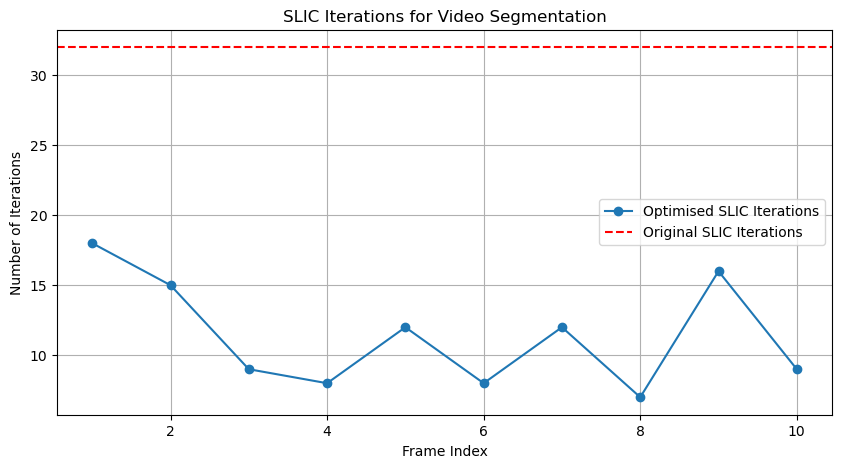

In [3]:
print(optimised_slic_iters)

frame_indices = list(range(1, len(optimised_slic_iters) + 1))

plt.figure(figsize=(10, 5))
plt.plot(frame_indices, optimised_slic_iters, marker='o', linestyle='-', label="Optimised SLIC Iterations")
plt.axhline(y=og_slic_iters, color='r', linestyle='--', label="Original SLIC Iterations")

plt.xlabel("Frame Index")
plt.ylabel("Number of Iterations")
plt.title("SLIC Iterations for Video Segmentation")
plt.legend()
plt.grid()

plt.show()